# Loading data fron Kaggle

In [2]:
#!pip install kaggle

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# Ensure the Kaggle directory exists and set the permissions without trying to recreate it
!mkdir -p ~/.kaggle  # The -p flag ensures that mkdir doesn't throw an error if the directory already exists
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d yuerugong/project1-zeta-surgical

100% 9.42G/9.44G [01:53<00:00, 79.6MB/s]
100% 9.44G/9.44G [01:53<00:00, 89.2MB/s]


In [4]:
!unzip -q '/content/project1-zeta-surgical.zip' -d '/content/'

In [5]:
!ls /content/renders/renders/



epidural  intraparenchymal  intraventricular  multi  normal  subarachnoid  subdural


In [6]:
!ls /content

 flagged.txt
 hemorrhage-labels.csv
 kaggle.json
 project1-zeta-surgical.zip
 renders
'Results_Brain Hemorrhage Tracing_2020-09-28_15.21.52.597.csv'
'Results_Epidural Hemorrhage Detection_2020-11-16_21.31.26.148.csv'
'Results_Intraparenchymal Hemorrhage Detection_2020-11-16_21.39.31.268.csv'
'Results_Multiple Hemorrhage Detection_2020-11-16_21.36.24.018.csv'
'Results_Subarachnoid Hemorrhage Detection_2020-11-16_21.36.18.668.csv'
'Results_Subdural Hemorrhage Detection_2020-11-16_21.35.48.040.csv'
'Results_Subdural Hemorrhage Detection_2020-11-16_21.37.19.745.csv'
 sample_data
'Segmentation Glossary (1).rtf'
'Segmentation Glossary.rtf'


In [7]:
!find /content -name 'project1-zeta-surgical.zip'


/content/project1-zeta-surgical.zip


# Library Import

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
import tensorflow as tf
import keras
import seaborn as sns
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
#from sklearn.preprocessing import OneHotEncoder
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Loading The Data - 1000 Each

In [3]:
hemmorrhage_labels_df = pd.read_csv('hemorrhage-labels.csv')
hemmorrhage_labels_df

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752798,ID_ffff82e46,0,0,0,0,0,0
752799,ID_ffff922b9,1,0,0,1,0,0
752800,ID_ffffb670a,1,0,0,0,1,0
752801,ID_ffffcbff8,0,0,0,0,0,0


In [4]:
# Flagged data
f = open("flagged.txt", "r")
flagged = [file.replace('\n','') for file in f.readlines()]
flagged += ['ID_6431af929.jpg']
flagged

['ID_20440abc6.jpg',
 'ID_1811d9bf2.jpg',
 'ID_75a698178.jpg',
 'ID_30010d605.jpg',
 'ID_34b04fff9.jpg',
 'ID_432bad415.jpg',
 'ID_3cb85bfca.jpg',
 'ID_4dad8b080.jpg',
 'ID_6431af929.jpg']

In [5]:
# Segmented Epidural Data
epidural_results = pd.read_csv("Results_Epidural Hemorrhage Detection_2020-11-16_21.31.26.148.csv")
epidural_results = epidural_results[(epidural_results['Majority Label'].str.len() != 0) & (epidural_results['Correct Label'].notna())]
segmented_epidural_images = epidural_results['Origin'].values

epidural_dir = '/content/renders/renders/epidural/'
epidural_max_contrast = []
for dirname, _, filenames in os.walk(epidural_dir):
    for filename in filenames:
        if (filename in segmented_epidural_images) & (filename not in flagged):
            epidural_max_contrast.append(os.path.join(dirname, filename))
        if (len(epidural_max_contrast)==1000):
            break
    else:
        continue
    break

epidural_data = []
epidural_label = []
for path in epidural_max_contrast:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (128,128,3)) & (len(label)==1)):
        epidural_data.append(np.array(img))
        epidural_label.append(label.values.flatten().tolist()[2:])

epidural_data = np.array(epidural_data)
print(epidural_data.shape)
epidural_label = np.array(epidural_label)
print(epidural_label.shape)

(1000, 128, 128, 3)
(1000, 5)


In [6]:
# Segmented Intraparenchymal Data
intraparenchymal_results = pd.read_csv("Results_Intraparenchymal Hemorrhage Detection_2020-11-16_21.39.31.268.csv")
intraparenchymal_results = intraparenchymal_results[(intraparenchymal_results['Majority Label'].str.len() != 0) & (intraparenchymal_results['Correct Label'].notna())]
segmented_intraparenchymal_images = intraparenchymal_results['Origin'].values

intraparenchymal_dir = '/content/renders/renders/intraparenchymal/'

intraparenchymal_max_constrast = []
for dirname, _, filenames in os.walk(intraparenchymal_dir):
    for filename in filenames:
        if (filename in segmented_intraparenchymal_images) & (filename not in flagged):
            intraparenchymal_max_constrast.append(os.path.join(dirname, filename))
        if (len(intraparenchymal_max_constrast)==1000):
            break
    else:
        continue
    break

intraparenchymal_data = []
intraparenchymal_label = []
for path in intraparenchymal_max_constrast:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (128,128,3)) & (len(label)==1)):
        intraparenchymal_data.append(np.array(img))
        intraparenchymal_label.append(label.values.flatten().tolist()[2:])

intraparenchymal_data = np.array(intraparenchymal_data)
print(intraparenchymal_data.shape)
intraparenchymal_label = np.array(intraparenchymal_label)
print(intraparenchymal_label.shape)

(1000, 128, 128, 3)
(1000, 5)


In [7]:
# Segmented Subarachnoid Data
subarachnoid_results = pd.read_csv('Results_Subarachnoid Hemorrhage Detection_2020-11-16_21.36.18.668.csv')
subarachnoid_results = subarachnoid_results[(subarachnoid_results['Majority Label'].str.len() != 0) & (subarachnoid_results['Correct Label'].notna())]
segmented_subarachnoid_images = subarachnoid_results['Origin'].values
subarachnoid_dir = '/content/renders/renders/subarachnoid/'
subarachnoid_max_constrast = []
for dirname, _, filenames in os.walk(subarachnoid_dir):
    for filename in filenames:
        if (filename in segmented_subarachnoid_images) & (filename not in flagged):
            subarachnoid_max_constrast.append(os.path.join(dirname, filename))
        if (len(subarachnoid_max_constrast)==1000):
            break
    else:
        continue
    break

subarachnoid_data = []
subarachnoid_label = []
for path in subarachnoid_max_constrast:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (128,128,3)) & (len(label)==1)):
        subarachnoid_data.append(np.array(img))
        subarachnoid_label.append(label.values.flatten().tolist()[2:])

subarachnoid_data = np.array(subarachnoid_data)
print(subarachnoid_data.shape)
subarachnoid_label = np.array(subarachnoid_label)
print(subarachnoid_label.shape)


(840, 128, 128, 3)
(840, 5)


In [8]:
# Segmented Subdural Data
subdural_results = pd.read_csv("Results_Subdural Hemorrhage Detection_2020-11-16_21.35.48.040.csv")
subdural_results = subdural_results[(subdural_results['Majority Label'].str.len() != 0) & (subdural_results['Correct Label'].notna())]
segmented_subdural_images = subdural_results['Origin'].values
subdural_max_constrast = []
subdural_dir = '/content/renders/renders/subdural/'
for dirname, _, filenames in os.walk(subdural_dir):
    for filename in filenames:
        if (filename in segmented_subdural_images) & (filename not in flagged):
            subdural_max_constrast.append(os.path.join(dirname, filename))
        if (len(subdural_max_constrast)==1000):
            break
    else:
        continue
    break

subdural_data = []
subdural_label = []
for path in subdural_max_constrast:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (128,128,3)) & (len(label)==1)):
        subdural_data.append(np.array(img))
        subdural_label.append(label.values.flatten().tolist()[2:])

subdural_data = np.array(subdural_data)
print(subdural_data.shape)
subdural_label = np.array(subdural_label)
print(subdural_label.shape)

(828, 128, 128, 3)
(828, 5)


In [9]:
# Segmented Multiple Data
multiple_results = pd.read_csv("Results_Multiple Hemorrhage Detection_2020-11-16_21.36.24.018.csv")
multiple_results = multiple_results[(multiple_results['Majority Label'].str.len() != 0) & (multiple_results['Correct Label'].notna())]
segmented_multiple_images = multiple_results['Origin'].values
multiple_dir = '/content/renders/renders/multi/'
multiple_max_constrast = []
for dirname, _, filenames in os.walk(multiple_dir):
    for filename in filenames:
        if (filename in segmented_multiple_images) & (filename not in flagged):
            multiple_max_constrast.append(os.path.join(dirname, filename))
        if (len(multiple_max_constrast)==1000):
            break
    else:
        continue
    break

multiple_data = []
multiple_label = []
for path in multiple_max_constrast:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (128,128,3)) & (len(label)==1)):
        multiple_data.append(np.array(img))
        multiple_label.append(label.values.flatten().tolist()[2:])

multiple_data = np.array(multiple_data)
print(multiple_data.shape)
multiple_label = np.array(multiple_label)
print(multiple_label.shape)

(804, 128, 128, 3)
(804, 5)


In [10]:
# Intraventricular Data
intraventricular_dir = '/content/renders/renders/intraventricular/'
intraventricular_max_constrast = []
for dirname, _, filenames in os.walk(intraventricular_dir):
    for filename in filenames:
        if (filename not in flagged):
            intraventricular_max_constrast.append(os.path.join(dirname, filename))
        if (len(intraventricular_max_constrast)==1000):
            break
    else:
        continue
    break


intraventricular_data = []
intraventricular_label = []
for path in intraventricular_max_constrast:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    base_filename = os.path.basename(path)
    label = hemmorrhage_labels_df[hemmorrhage_labels_df['Image']==base_filename.replace('.jpg', '')]
    if((img.shape == (128,128,3)) & (len(label)==1)):
        intraventricular_data.append(np.array(img))
        intraventricular_label.append(label.values.flatten().tolist()[2:])

intraventricular_data = np.array(intraventricular_data)
print(intraventricular_data.shape)
intraventricular_label = np.array(intraventricular_label)
print(intraventricular_label.shape)


(1000, 128, 128, 3)
(1000, 5)


In [11]:
# Normal Data
normal_dir = '/content/renders/renders/normal/'
normal_max_constrast = []
for dirname, _, filenames in os.walk(normal_dir):
    for filename in filenames:
        if (filename not in flagged):
            normal_max_constrast.append(os.path.join(dirname, filename))
        if (len(normal_max_constrast)==1000):
            break
    else:
        continue
    break


normal_data = []
normal_label = []
for path in normal_max_constrast:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if((img.shape == (128,128,3)) & (len(label)==1)):
        normal_data.append(np.array(img))
        normal_label.append([0,0,0,0,0])

normal_data = np.array(normal_data)
print(normal_data.shape)
normal_label = np.array(normal_label)
print(normal_label.shape)


(1000, 128, 128, 3)
(1000, 5)


# Data Preprocessing

In [12]:
# Combine all the data
all_data = np.vstack((epidural_data,intraparenchymal_data,subarachnoid_data,subdural_data,multiple_data,intraventricular_data,normal_data))
all_label = np.vstack((epidural_label,intraparenchymal_label,subarachnoid_label,subdural_label,multiple_label,intraventricular_label,normal_label))
print(all_data.shape)
print(all_label.shape)

(6472, 128, 128, 3)
(6472, 5)


In [13]:
# Shuffle the data
shuffle_index = np.random.permutation(all_data.shape[0])
X_data = all_data[shuffle_index]
y_data = all_label[shuffle_index]

In [14]:
# Split train, test, val
[X_train, X_rest, y_train, y_rest] = train_test_split(X_data, y_data, test_size = 0.2, random_state=0)
[X_val, X_test, y_val, y_test] = train_test_split(X_rest, y_rest, test_size=0.5, random_state=0)

In [15]:
# Normalize the data
X_train = X_train / 255.
X_test = X_test / 255.
X_val = X_val / 255.

In [16]:
## Add an extra dimension
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
X_val = X_val.reshape(-1, 128, 128, 3)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_val.shape)
print(y_val.shape)


(5177, 128, 128, 3)
(5177, 5)
(648, 128, 128, 3)
(648, 5)
(647, 128, 128, 3)
(647, 5)


# Transfer Learning

In [23]:
# Load a pretrained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_tensor=Input(shape=(128, 128, 3)))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the appropriate loss function
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the data
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print the test set accuracy
print(f"Test accuracy: {test_acc}")


Epoch 1/100
162/162 [==============================] - 8s 28ms/step - loss: 1.6131 - accuracy: 0.2722 - val_loss: 1.6051 - val_accuracy: 0.3277
Epoch 2/100
162/162 [==============================] - 3s 21ms/step - loss: 1.4921 - accuracy: 0.3454 - val_loss: 1.5622 - val_accuracy: 0.3447
Epoch 3/100
162/162 [==============================] - 4s 22ms/step - loss: 1.4365 - accuracy: 0.3734 - val_loss: 1.5263 - val_accuracy: 0.3493
Epoch 4/100
162/162 [==============================] - 3s 20ms/step - loss: 1.4011 - accuracy: 0.3838 - val_loss: 1.4978 - val_accuracy: 0.3617
Epoch 5/100
162/162 [==============================] - 3s 19ms/step - loss: 1.3723 - accuracy: 0.4020 - val_loss: 1.4873 - val_accuracy: 0.3524
Epoch 6/100
162/162 [==============================] - 3s 19ms/step - loss: 1.3513 - accuracy: 0.4149 - val_loss: 1.4754 - val_accuracy: 0.3679
Epoch 7/100
162/162 [==============================] - 3s 21ms/step - loss: 1.3322 - accuracy: 0.4248 - val_loss: 1.4662 - val_accuracy:

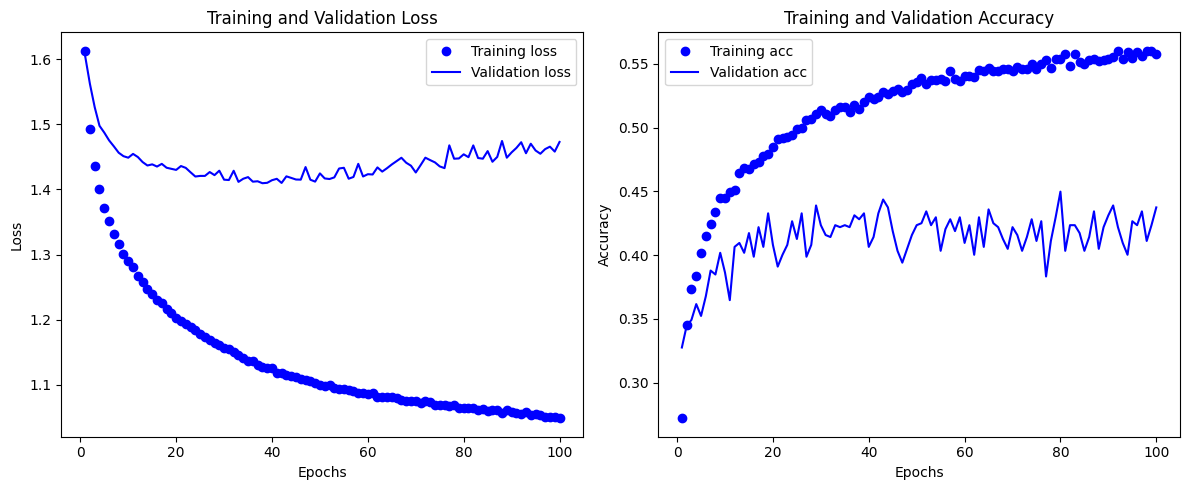

In [24]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      